In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
orders = pd.read_csv("/content/drive/MyDrive/restaurant-1-orders.csv")
prices = pd.read_csv("/content/drive/MyDrive/restaurant-1-products-price.csv")

In [4]:
orders.head()

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6


In [5]:
from dateutil.parser import parse 

In [6]:
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120}) #update default settings of matplotlib

In [7]:
orders["Order Date"] = pd.to_datetime(orders["Order Date"], dayfirst = True) #convert the "Order Date" column into a datetime data type
orders.head()

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,2019-08-03 20:25:00,Plain Papadum,2,0.80,6
1,16118,2019-08-03 20:25:00,King Prawn Balti,1,12.95,6
2,16118,2019-08-03 20:25:00,Garlic Naan,1,2.95,6
3,16118,2019-08-03 20:25:00,Mushroom Rice,1,3.95,6
4,16118,2019-08-03 20:25:00,Paneer Tikka Masala,1,8.95,6


In [8]:
orders = orders.dropna() #Remove rows with null values

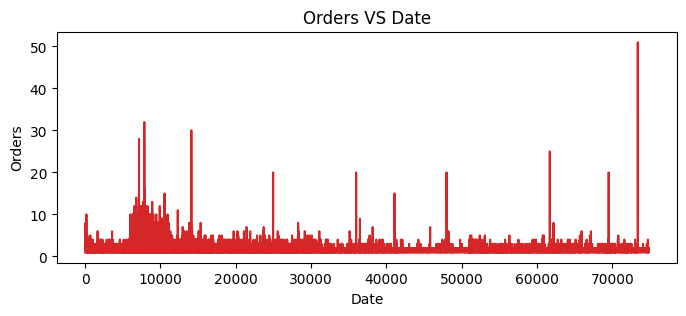

In [9]:
def plot_df(df, x, y,xlabel="Date",ylabel="Orders", dpi=100):
    plt.figure(figsize=(8,3), dpi = dpi)
    plt.plot(x,y,color='tab:red')
    plt.gca().set(xlabel=xlabel, ylabel=ylabel)
    plt.title("Orders VS Date")
    plt.show()
plot_df(orders, x=orders.index, y= orders["Quantity"])

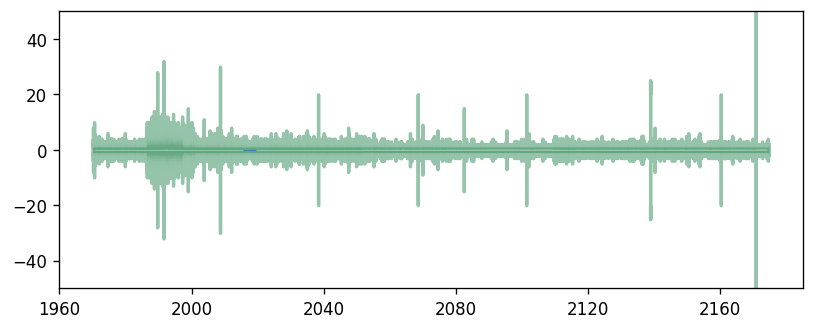

In [10]:
x = orders.index.values
y1 = orders["Quantity"].values
fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-50, 50)
plt.hlines(y=0, xmin=np.min(orders["Order Date"]), xmax=np.max(orders["Order Date"]), linewidth=.5)
plt.show()

In [11]:
#we can see that from 08/2016 is when orders become consistent, so these the values we will use for the model
orders = orders.loc[orders['Order Date'] >='2016-08-01']

In [12]:
orders.head()

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,2019-08-03 20:25:00,Plain Papadum,2,0.80,6
1,16118,2019-08-03 20:25:00,King Prawn Balti,1,12.95,6
2,16118,2019-08-03 20:25:00,Garlic Naan,1,2.95,6
3,16118,2019-08-03 20:25:00,Mushroom Rice,1,3.95,6
4,16118,2019-08-03 20:25:00,Paneer Tikka Masala,1,8.95,6


In [13]:
print("Daily:\n", orders.groupby([pd.Grouper(key='Order Date', freq='D')])['Quantity'].sum().mean())
print("Weekly:\n", orders.groupby([pd.Grouper(key='Order Date', freq='W-MON')])['Quantity'].sum().mean())
print("Monthly:\n", orders.groupby([pd.Grouper(key='Order Date', freq='M')])['Quantity'].sum().mean())

Daily:
 80.61713764813126
Weekly:
 563.2929936305733
Monthly:
 2390.189189189189


In [14]:
#Creating relevant database df for total and df2 for food item: bombay aloo
df = orders[['Order Date', 'Quantity']]
df2 = orders[orders['Item Name'] == 'Bombay Aloo']
df2 = df2[['Order Date', 'Quantity']]
df = df.groupby([pd.Grouper(key='Order Date', freq='W-MON')])['Quantity'].sum().reset_index().sort_values('Order Date')
df2 = df2.groupby([pd.Grouper(key='Order Date', freq='W-MON')])['Quantity'].sum().reset_index().sort_values('Order Date')

In [15]:
#Adding seasonality features
df['Week'] = df['Order Date'].dt.isocalendar().week
df['Month'] = df['Order Date'].dt.month
df2['Week'] = df2['Order Date'].dt.isocalendar().week
df2['Month'] = df2['Order Date'].dt.month

In [16]:
#Adding past volume features
for i in range (1,15):
    label = "Quantity_" + str(i)
    df[label] = df['Quantity'].shift(i)
    df2[label] = df2['Quantity'].shift(i)
    label = "Average_" + str(i)
    df[label] = df['Quantity'].rolling(i).mean()
    df2[label] = df2['Quantity'].rolling(i).mean()
df = df.dropna()
df2 = df2.dropna()

In [17]:
df.head()

,Order Date,Quantity,Week,Month,Quantity_1,Average_1,Quantity_2,Average_2,Quantity_3,Average_3,...,Quantity_10,Average_10,Quantity_11,Average_11,Quantity_12,Average_12,Quantity_13,Average_13,Quantity_14,Average_14
14,2016-11-14,451,46,11,416.0,451.0,406.0,433.5,424.0,424.333333,...,395.0,411.6,330.0,410.090909,345.0,403.416667,285.0,398.923077,368.0,390.785714
15,2016-11-21,442,47,11,451.0,442.0,416.0,446.5,406.0,436.333333,...,326.0,423.2,395.0,414.363636,330.0,412.750000,345.0,406.384615,285.0,402.000000
16,2016-11-28,431,48,11,442.0,431.0,451.0,436.5,416.0,441.333333,...,301.0,436.2,326.0,423.909091,395.0,415.750000,330.0,414.153846,345.0,408.142857
17,2016-12-05,450,49,12,431.0,450.0,442.0,440.5,451.0,441.000000,...,365.0,444.7,301.0,437.454545,326.0,426.083333,395.0,418.384615,330.0,416.714286
18,2016-12-12,371,50,12,450.0,371.0,431.0,410.5,442.0,417.333333,...,434.0,438.4,365.0,438.000000,301.0,431.916667,326.0,421.846154,395.0,415.000000


In [19]:
df2.head()

,Order Date,Quantity,Week,Month,Quantity_1,Average_1,Quantity_2,Average_2,Quantity_3,Average_3,...,Quantity_10,Average_10,Quantity_11,Average_11,Quantity_12,Average_12,Quantity_13,Average_13,Quantity_14,Average_14
14,2016-11-14,9,46,11,14.0,9.0,5.0,11.5,9.0,9.333333,...,10.0,8.6,6.0,8.727273,8.0,8.500000,6.0,8.461538,6.0,8.285714
15,2016-11-21,10,47,11,9.0,10.0,14.0,9.5,5.0,11.000000,...,7.0,8.9,10.0,8.727273,6.0,8.833333,8.0,8.615385,6.0,8.571429
16,2016-11-28,14,48,11,10.0,14.0,9.0,12.0,14.0,11.000000,...,8.0,9.5,7.0,9.363636,10.0,9.166667,6.0,9.230769,8.0,9.000000
17,2016-12-05,12,49,12,14.0,12.0,10.0,13.0,9.0,12.000000,...,4.0,10.3,8.0,9.727273,7.0,9.583333,10.0,9.384615,6.0,9.428571
18,2016-12-12,6,50,12,12.0,6.0,14.0,9.0,10.0,10.666667,...,11.0,9.8,4.0,9.909091,8.0,9.416667,7.0,9.307692,10.0,9.142857


In [20]:
#Encoding using pandas get_dummies
for column in ['Week','Month']:
    tempdf = pd.get_dummies(df[column], prefix=column)
    df = pd.merge(
        left=df,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df = df.drop(columns=column)
df.shape

(143, 94)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
from xgboost import XGBRegressor
#143 rows so we split the data up to row 107 for train and test sets for df
train = df[:107].drop('Order Date', axis = 1)
test = df[107:].drop('Order Date', axis = 1)
xtrain = train.drop(['Quantity'], axis = 1)
xtest = test.drop(['Quantity'], axis = 1)
ytrain = train['Quantity']
ytest =test['Quantity']

In [22]:
#Model for df
model = XGBRegressor(n_estimators=500, learning_rate=0.01)
eval_set = [(xtrain, ytrain)]
model.fit(xtrain, ytrain, eval_metric="rmsle", eval_set=eval_set, early_stopping_rounds=20, verbose=False)
ypred = model.predict(xtest)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [23]:
#First we add the results to our original dataframe, after first aligning the indexes
#df
ypred = pd.Series(ypred)
eval_df = df[107:].reset_index(drop = True)
eval_df['ypred'] = ypred
eval_df = eval_df[['Order Date','Quantity', 'ypred']]
eval_df.head()

,Order Date,Quantity,ypred
0,2018-12-03,816,806.957397
1,2018-12-10,685,685.802979
2,2018-12-17,789,771.372009
3,2018-12-24,910,796.435364
4,2018-12-31,808,796.435364


Text(0.5, 1.0, 'Total Sales')

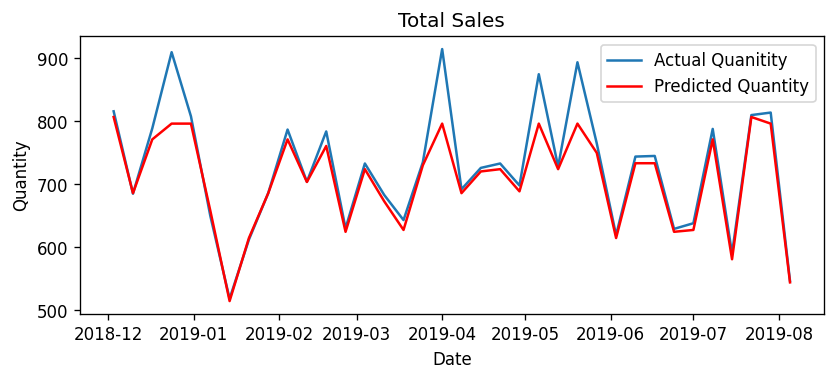

In [27]:
#Plot the results of the train vs test sets
plt.figure(figsize = (8,3))
plt.plot(eval_df['Order Date'], eval_df['Quantity'], label = "Actual Quanitity")
plt.plot(eval_df['Order Date'], eval_df['ypred'], color = 'red', label = 'Predicted Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title("Actual Quantity VS Predicted Quantity")
plt.legend()
plt.title('Total Sales')

In [28]:
#Metrics: mean_absolute_error, r2_score, mean_squared_log_error
print("Metrics for Total Sale\n")
print("Mean Absolute Error:\n", mean_absolute_error(ytest, ypred))
print("R Squared:\n", r2_score(ytest, ypred))
print("Mean Squared Log Error:\n", mean_squared_log_error(ytest, ypred))

Metrics for Total Sale

Mean Absolute Error:
 19.064644707573784
R Squared:
 0.8612014909506002
Mean Squared Log Error:
 0.0018199349961926083
